Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


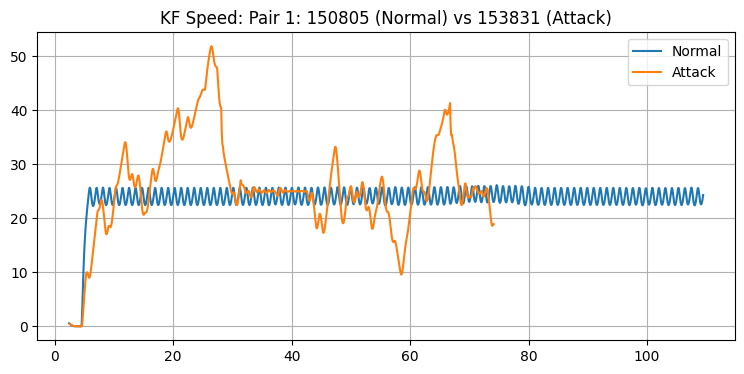

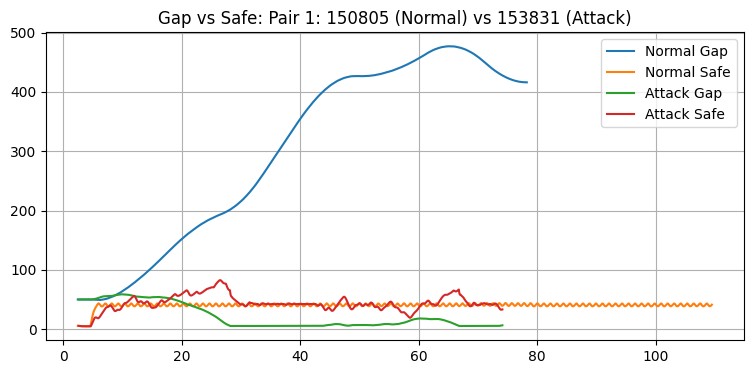

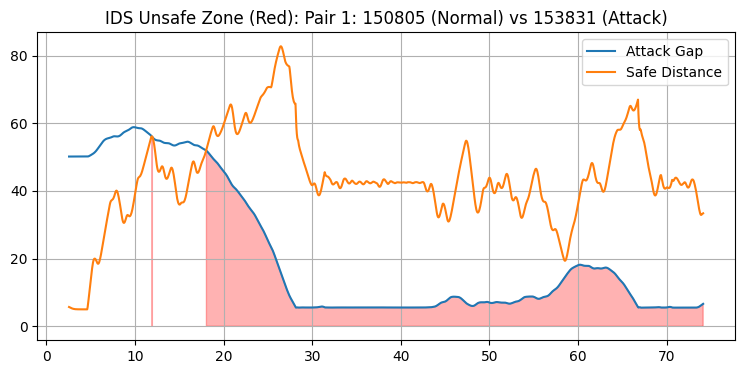

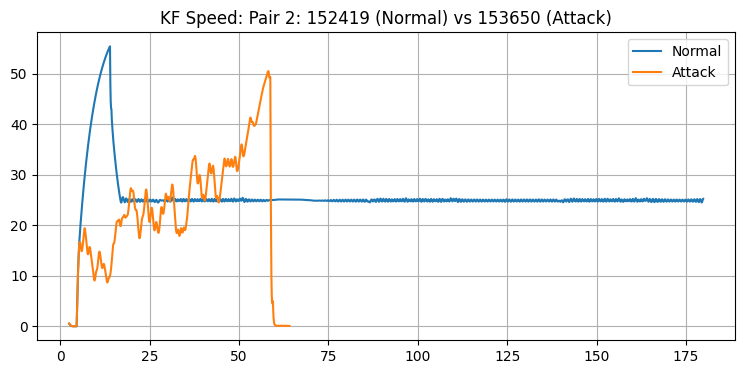

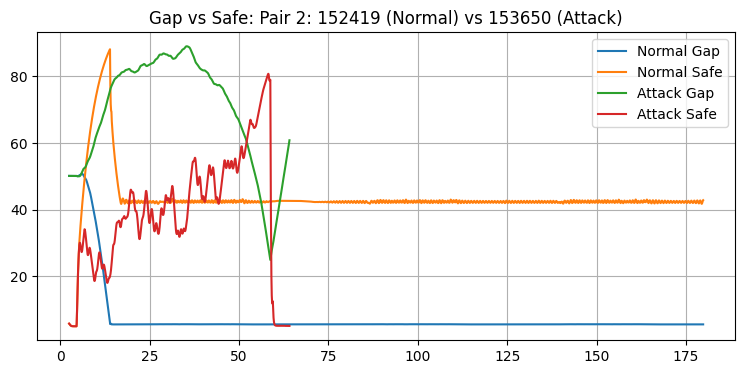

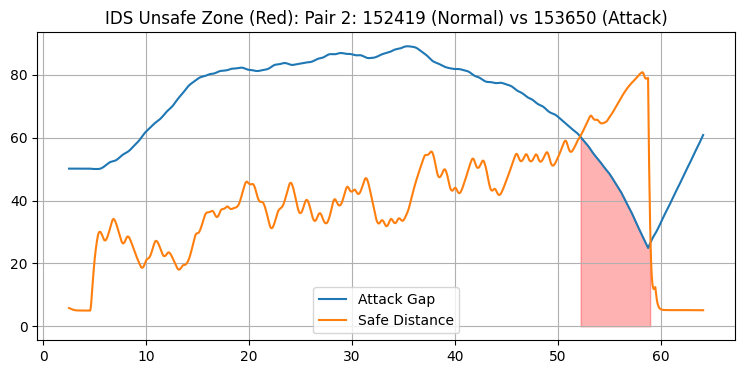

In [28]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================================
# Telemetry File Pairs
# ================================
# Pair 1 (main normal vs attack)
normal_1 = "/content/drive/MyDrive/acc/acc20220924-150805.csv"
attack_1 = "/content/drive/MyDrive/acc/acc20220924-153831.csv"

# Pair 2 (secondary normal vs attack)
normal_2 = "/content/drive/MyDrive/acc/acc20220924-152419.csv"
attack_2 = "/content/drive/MyDrive/acc/acc20220924-153650.csv"

required = [
    "timestamp",
    "ego_vehicle_x","ego_vehicle_y","ego_vehicle_z","ego_vehicle_v",
    "leader_vehicle_x","leader_vehicle_y","leader_vehicle_z","leader_vehicle_v"
]

# ================================
# Kalman Filter
# ================================
class KF:
    def __init__(self, x0, P0, Q, R):
        self.x = x0; self.P = P0; self.Q = Q; self.R = R
    def predict(self): self.P += self.Q
    def update(self, z):
        K = self.P/(self.P+self.R)
        self.x = self.x + K*(z-self.x)
        self.P = (1-K)*self.P
        return self.x

h = 1.5
d0 = 5.0

# ================================
# Process Function
# ================================
def run(path):
    df = pd.read_csv(path)
    if not all(c in df.columns for c in required):
        raise ValueError(f"{path} missing telemetry columns")

    z = df["ego_vehicle_v"].values
    kf = KF(z[0], 10, 0.01, 0.1)
    est = []
    for v in z:
        kf.predict()
        est.append(kf.update(v))
    df["ego_vehicle_v_kf"] = est

    dx = df["ego_vehicle_x"] - df["leader_vehicle_x"]
    dy = df["ego_vehicle_y"] - df["leader_vehicle_y"]
    dz = df["ego_vehicle_z"] - df["leader_vehicle_z"]
    df["gap"] = np.sqrt(dx*dx + dy*dy + dz*dz)

    df["d_safe"] = h*df["ego_vehicle_v_kf"] + d0
    df["IDS_trigger"] = df["gap"] < df["d_safe"]
    return df

# ================================
# Run Both Pairs
# ================================
dfN1, dfA1 = run(normal_1), run(attack_1)
dfN2, dfA2 = run(normal_2), run(attack_2)

# ================================
# Plotting Helper
# ================================
def compare(dfN, dfA, title):
    # Speed comparison
    plt.figure(figsize=(9,4))
    plt.plot(dfN["timestamp"], dfN["ego_vehicle_v_kf"], label="Normal")
    plt.plot(dfA["timestamp"], dfA["ego_vehicle_v_kf"], label="Attack")
    plt.title(f"KF Speed: {title}")
    plt.grid(); plt.legend(); plt.show()

    # Gap vs safe distance
    plt.figure(figsize=(9,4))
    plt.plot(dfN["timestamp"], dfN["gap"], label="Normal Gap")
    plt.plot(dfN["timestamp"], dfN["d_safe"], label="Normal Safe")
    plt.plot(dfA["timestamp"], dfA["gap"], label="Attack Gap")
    plt.plot(dfA["timestamp"], dfA["d_safe"], label="Attack Safe")
    plt.title(f"Gap vs Safe: {title}")
    plt.grid(); plt.legend(); plt.show()

    # IDS unsafe zone
    plt.figure(figsize=(9,4))
    plt.plot(dfA["timestamp"], dfA["gap"], label="Attack Gap")
    plt.plot(dfA["timestamp"], dfA["d_safe"], label="Safe Distance")
    plt.fill_between(dfA["timestamp"], 0, dfA["gap"],
                     where=dfA["IDS_trigger"],
                     color='red', alpha=0.3)
    plt.title(f"IDS Unsafe Zone (Red): {title}")
    plt.grid(); plt.legend(); plt.show()

# ================================
# SHOW RESULTS
# ================================
compare(dfN1, dfA1, "Pair 1: 150805 (Normal) vs 153831 (Attack)")
compare(dfN2, dfA2, "Pair 2: 152419 (Normal) vs 153650 (Attack)")
